# Plotting jets as images

In [1]:
import time
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray, MaskedArray
import numpy as np
import glob as glob
import itertools
import json
import uproot_methods
import copy
from coord_transform import *
import tensorflow as tf
import pandas as pd
import math

np.set_printoptions(threshold=np.inf)

In [2]:
def pseudorapidity(theta):
    return -np.log(np.tan(theta*0.5))

In [3]:
def dataStream(output):
    
    image = output['flippedImages'].value
    jetPt = output['jetPt'].value
    jetEta = output['jetEta'].value
    jetPhi = output['jetPhi'].value
    jetconstPt_log = output['jetconstPt_log'].value
    jetconstPt_Jetlog = output['jetconstPt_Jetlog'].value
    jetconstE_log = output['jetconstE_log'].value
    jetconstEta_abs = np.abs(output['jetconstEta'].value)
    delta_eta = output['delta_eta'].value
    delta_phi = output['delta_phi'].value
    deltaR_jet = output['deltaR_jet'].value
    deltaR_subjet0 = output['deltaR_subjet0'].value
    deltaR_subjet1 = output['deltaR_subjet1'].value
    charge = output['charge'].value
    isEle = output['isEle'].value
    isPho = output['isPho'].value
    isMuon = output['isMuon'].value
    isCh = output['isCh'].value
    isNh = output['isNh'].value
    dz = output['dz'].value
    dxy = output['dxy'].value
    labels = output['label'].value
    chMult = output['chargedHadronMult'].value
    neutMult = output['neutralHadronMult'].value
    phoMult = output['photonMult'].value
    eleMult = output['electronMult'].value
    muMult = output['muonMult'].value
    jetTau21 = output['jetTau21'].value
    jetTau31 = output['jetTau31'].value
    jetTau32 = output['jetTau32'].value
    jetTau21_sd = output['jetTau21_sd'].value
    jetTau31_sd = output['jetTau31_sd'].value
    jetTau32_sd = output['jetTau32_sd'].value
    jetpull = output['pull_angle'].value

    
    jetFile = '/mnt/data/ml/ShowJetsData_addgroomedta'
    constituentFile = '/mnt/data/ml/Constituent4vec_addgroomedta'
      

    np.savez(jetFile, jetImages = image, jetPt = jetPt, jetEta = jetEta, jetPhi = jetPhi,
             tau21=jetTau21, tau31=jetTau31, tau32=jetTau32, chMult=chMult, neutMult = neutMult, 
             phoMult=phoMult, eleMult=eleMult, muMult=muMult, jetpull=jetpull, labels = labels)
    
    labels = np.repeat(labels, 20, axis=0).reshape(len(labels)*20, 2)
    jetTau21 = np.repeat(jetTau21, 20, axis=0).reshape(len(jetTau21)*20)
    jetTau31 = np.repeat(jetTau31, 20, axis=0).reshape(len(jetTau31)*20)
    jetTau32 = np.repeat(jetTau32, 20, axis=0).reshape(len(jetTau32)*20)
    jetTau21_sd = np.repeat(jetTau21_sd, 20, axis=0).reshape(len(jetTau21_sd)*20)
    jetTau31_sd = np.repeat(jetTau31_sd, 20, axis=0).reshape(len(jetTau31_sd)*20)
    jetTau32_sd = np.repeat(jetTau32_sd, 20, axis=0).reshape(len(jetTau32_sd)*20)
    jetpull = np.repeat(jetpull, 20, axis=0).reshape(len(jetpull)*20)

    np.savez(constituentFile, jetconstPt_log = jetconstPt_log, jetconstEta_abs = jetconstEta_abs,
             jetconstE_log = jetconstE_log, jetconstPt_Jetlog = jetconstPt_Jetlog, tau21=jetTau21,
             tau31=jetTau31, tau32=jetTau32, charge=charge, isEle = isEle,isPho = isPho, isMuon=isMuon,
             isCh=isCh, isNh=isNh, delta_eta=delta_eta, delta_phi = delta_phi, deltaR_jet = deltaR_jet,
             deltaR_subjet0 = deltaR_subjet0, deltaR_subjet1=deltaR_subjet1, jetpull = jetpull, dxy=dxy,
             dz=dz, labels = labels)

In [4]:
def transform_to_softdrop_axes(jetparticles,Jets):
    
    subjet0leading = (Jets.subjet0_pt > Jets.subjet1_pt)
    centroid1_pt = np.where( subjet0leading, Jets.subjet0_pt, Jets.subjet1_pt  )
    centroid1_eta = np.where( subjet0leading, Jets.subjet0_eta, Jets.subjet1_eta  )
    centroid1_phi = np.where( subjet0leading, Jets.subjet0_phi, Jets.subjet1_phi  )
    centroid1_m = np.where( subjet0leading, Jets.subjet0_m, Jets.subjet1_m  )
    centroid2_pt = np.where( subjet0leading, Jets.subjet1_pt, Jets.subjet0_pt,   )
    centroid2_eta = np.where( subjet0leading, Jets.subjet1_eta, Jets.subjet0_eta  )
    centroid2_phi = np.where( subjet0leading, Jets.subjet1_phi, Jets.subjet0_phi  )
    centroid2_m = np.where( subjet0leading, Jets.subjet1_m, Jets.subjet0_m  )
    pcentroid1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid1_pt, centroid1_eta, centroid1_phi, centroid1_m )
    pcentroid2 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid2_pt, centroid2_eta, centroid2_phi, centroid2_m )
    
    #distance between the two centroids
    r0 = pcentroid1.delta_r(pcentroid2)
    
    centroid1 = uproot_methods.TVector3Array.from_cartesian(pcentroid1.x, pcentroid1.y, pcentroid1.z)
    centroid2 = uproot_methods.TVector3Array.from_cartesian(pcentroid2.x, pcentroid2.y, pcentroid2.z)
    particle_p3s = uproot_methods.TVector3Array.from_cartesian(jetparticles.p4.x, jetparticles.p4.y, jetparticles.p4.z)
    
    # Rotate coordinate system so "centroid1" is along the x axis
    rot1_axis, rot1_angle = coord_rotation( centroid1, uproot_methods.TVector3(1,0,0) )    
    centroid1 = centroid1.rotate_axis(rot1_axis, rot1_angle)
    centroid2 = centroid2.rotate_axis(rot1_axis, rot1_angle)
    particle_p3s = particle_p3s.rotate_axis(rot1_axis, rot1_angle)

    # Rotate about the z axis so that centroid2 is pointing down
    rot2_angle = -np.arctan2( centroid2.z, centroid2.y )
    centroid2 = centroid2.rotatex(rot2_angle)
    particle_p3s = particle_p3s.rotatex(rot2_angle)
    
    # Scale the image so that centroid2 is at (0,1,0)
    deta = np.divide(pseudorapidity(particle_p3s.theta),r0)
    dphi = np.divide(particle_p3s.phi,r0)
        
    return deta,dphi,centroid1,centroid2

In [5]:
# import uproot
# file = uproot.open("/mnt/data/ml/zz_flatter_addgroomedtau.root")['T']
# file.keys()

In [6]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        self.eta_bins = 16
        self.phi_bins = 16
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        event_axis = hist.Bin("event", "Event number", 10000, 0, 10000 )
        pdgid_axis = hist.Bin("pdgid", r"PDG ID", 10000, -5000, 5000)
        eta_axis = hist.Bin("eta", r"$\eta$", 32, -5, 5)
        phi_axis = hist.Bin("phi", r"$\phi$", 32, -np.pi, np.pi)
        image_dphi = hist.Bin("image_dphi", r"$Q_1$", self.phi_bins, -2, 2) #yaxis
        image_deta = hist.Bin("image_deta", r"$Q_2$", self.eta_bins, -2, 2) #xaxis
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 1000, 0, 5000)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        dr_axis = hist.Bin("dr", r"$\Delta r$", 80, 0, 0.8)
        hadron_axis = hist.Cat("hadron", "Hadron Category") # hist.Cat -- list of categories
        tau_axis = hist.Bin("tau", r"$\tau$", 100, 0, 1.0)
        mult_axis = hist.Bin("mult", "Multiplicity", 50, 0, 50)
        pullAngle_axis = hist.Bin("pullAngle", "Jet Pull Angle", 50, -math.pi, math.pi)
        pull_axis = hist.Bin("pull", "Jet Pull", 100, 0, 0.1)

        
        self._accumulator = processor.dict_accumulator({
            #hists for plotting
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'h_hadmult':hist.Hist("Counts", dataset_axis, mult_axis, hadron_axis),# event_axis),
            'h_muMult':hist.Hist("Counts", dataset_axis, mult_axis),
            'h_eleMult':hist.Hist("Counts", dataset_axis, mult_axis),
            'h_phoMult':hist.Hist("Counts", dataset_axis, mult_axis),
            'h_jetPull':hist.Hist("Counts", dataset_axis, pull_axis),
            'h_jetPullAngle':hist.Hist("Counts", dataset_axis, pullAngle_axis),
            'image':hist.Hist(r"$p_{T}$", dataset_axis, event_axis, image_dphi, image_deta),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'dr_true':hist.Hist("Counts", dataset_axis, dr_axis),
            'pdgid':hist.Hist("Counts", dataset_axis, pdgid_axis),
            'tau21':hist.Hist("Counts", dataset_axis, tau_axis),
            'tau31':hist.Hist("Counts", dataset_axis, tau_axis),
            'tau32':hist.Hist("Counts", dataset_axis, tau_axis),
            
            #Column Accumulators for ML
            'flippedImages': processor.column_accumulator(np.zeros(shape=(0,16,16))),
            'jetEta': processor.column_accumulator(np.zeros(shape=(0))),
            'jetPhi': processor.column_accumulator(np.zeros(shape=(0))),
            'jetPt': processor.column_accumulator(np.zeros(shape=(0))),
            'jetTau21': processor.column_accumulator(np.zeros(shape=(0))),
            'jetTau31': processor.column_accumulator(np.zeros(shape=(0))),
            'jetTau32': processor.column_accumulator(np.zeros(shape=(0))),
            'jetTau21_sd': processor.column_accumulator(np.zeros(shape=(0))),
            'jetTau31_sd': processor.column_accumulator(np.zeros(shape=(0))),
            'jetTau32_sd': processor.column_accumulator(np.zeros(shape=(0))),
            'chargedHadronMult': processor.column_accumulator(np.zeros(shape=(0))),
            'neutralHadronMult': processor.column_accumulator(np.zeros(shape=(0))),
            'photonMult': processor.column_accumulator(np.zeros(shape=(0))),
            'electronMult': processor.column_accumulator(np.zeros(shape=(0))),
            'muonMult': processor.column_accumulator(np.zeros(shape=(0))), 
            'label': processor.column_accumulator(np.zeros(shape=(0,2))),
            'particleType':processor.column_accumulator(np.zeros(shape=(0))),
            
            'jetconstEvnum': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstEta': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstPhi': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstPt': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstE': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstPt_log': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstPt_Jetlog': processor.column_accumulator(np.zeros(shape=(0,20))),
            'jetconstE_log': processor.column_accumulator(np.zeros(shape=(0,20))),
            'delta_eta': processor.column_accumulator(np.zeros(shape=(0,20))),
            'delta_phi': processor.column_accumulator(np.zeros(shape=(0,20))),
            'deltaR_jet': processor.column_accumulator(np.zeros(shape=(0,20))),
            'deltaR_subjet0': processor.column_accumulator(np.zeros(shape=(0,20))),
            'deltaR_subjet1': processor.column_accumulator(np.zeros(shape=(0,20))),
            'charge': processor.column_accumulator(np.zeros(shape=(0,20))),
            'isEle': processor.column_accumulator(np.zeros(shape=(0,20))),
            'isPho': processor.column_accumulator(np.zeros(shape=(0,20))),
            'isMuon': processor.column_accumulator(np.zeros(shape=(0,20))),
            'isCh': processor.column_accumulator(np.zeros(shape=(0,20))),
            'isNh': processor.column_accumulator(np.zeros(shape=(0,20))),
            'dz': processor.column_accumulator(np.zeros(shape=(0,20))),
            'dxy': processor.column_accumulator(np.zeros(shape=(0,20))),
            
            'pull_angle':processor.column_accumulator(np.zeros(shape=(0))),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        
        output = self.accumulator.identity()

        dataset = df['dataset']
        evnum = df['eventNum']
        
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            nsubjet=df['jet_nsubjet'],
            subjet0_pt=df['jet_subjet0_pt'],
            subjet0_eta=df['jet_subjet0_eta'],
            subjet0_phi=df['jet_subjet0_phi'],
            subjet0_m=df['jet_subjet0_m'],
            subjet1_pt=df['jet_subjet1_pt'],
            subjet1_eta=df['jet_subjet1_eta'],
            subjet1_phi=df['jet_subjet1_phi'],
            subjet1_m=df['jet_subjet1_m'],
            tau1=df['jet_tau1'],
            tau2=df['jet_tau2'],
            tau3=df['jet_tau3'],
            tau4=df['jet_tau4'],
            tau1_sd=df['jet_tau1_sd'],
            tau2_sd=df['jet_tau2_sd'],
            tau3_sd=df['jet_tau3_sd'],
            tau4_sd=df['jet_tau4_sd'],
            vyy=df['gen_vyy'],
            vzz=df['gen_vzz'],
            ic=df['jet_ic'],
            nc=df['jet_nc']
            )        
        constituents = JaggedCandidateArray.candidatesfromcounts(
            df['nConstituent'],
            pt=df['constituent_pt'],
            eta=df['constituent_eta'],
            phi=df['constituent_phi'],
            mass=df['constituent_m'],
            pdgid=df['constituent_id'],
            status=df['constituent_status'],
            jetndx=df['constituent_jetndx'], # constituents belonging to the leading jet
            subjetndx=df['constituent_subjetndx'],
            vxx=df['constituent_vxx'],
            vyy=df['constituent_vyy'],
            vzz=df['constituent_vzz'],
            )
        
        deta,dphi,centroid1,centroid2= transform_to_softdrop_axes(constituents, Jets[:,0])        
        constituents.add_attributes( deta=deta )
        constituents.add_attributes( dphi=dphi )
        
        #Applying cuts toJets and Jet Constituents
        constituents = constituents[constituents.status==91] # only final state particles in the jet
        constituents = constituents[constituents.pt > 1]
        Jets = Jets[Jets.pt > 200]
        Jets = Jets[ Jets.nsubjet >= 2 ]
        oneJet = (Jets.counts >=1)
        Jets = Jets[oneJet]
        constituents = constituents[oneJet]
        
        dr = Jets[:,0].p4.delta_r(constituents.p4)
        jetconstituents=constituents[constituents.jetndx == 0]

        validImages = np.zeros(int(np.max(evnum)+1), dtype=bool)
        evnum = evnum[oneJet]
        validImages[evnum] = True
            
        deta = jetconstituents.deta
        dphi = jetconstituents.dphi
        
        # Get the leading 20 constituents in each event for
        # output to a npz file for deepak8 like architechtures. 
        truncated_constituents = jetconstituents[jetconstituents.pt.argsort()][:,:20]

        # Make a Jagged Array of event numbers with the correct offsets
        jaggedshape = JaggedArray.fromoffsets( jetconstituents.offsets, np.ones(deta.flatten().shape[0]))
        eventReshaped = jaggedshape * evnum
        
        # Performing parity flip so that sum(right) is higher than sum(left) for each image
        eventbins = np.arange(len(validImages)+1)
        xbins= np.linspace(-2,2,num=self.eta_bins+1)
        ybins= np.linspace(-2,2,num=self.phi_bins+1)
        
        # For the images, normalize each constituent to the jet pt
        # to remove any pt dependence
        const_pts = jetconstituents.pt
        normed_pts = const_pts / Jets[:,0].p4.pt
        
        #print('normed_pts = ', normed_pts)
    
        H_images = np.histogramdd((eventReshaped.flatten(),dphi.flatten(),deta.flatten()),
                                  bins=(eventbins ,ybins, xbins), weights = normed_pts.flatten())[0]
        H_images = H_images[validImages]
        mask = (np.sum(H_images[:,:,:int(self.eta_bins/2)], axis = (1,2)) < np.sum(H_images[:,:,int(self.eta_bins/2):], axis = (1,2)))
        sign = np.where(mask, 1, -1)
        deta = (sign*deta)
        H_images_new = np.histogramdd((eventReshaped.flatten(),dphi.flatten(),deta.flatten()),
                                      bins=(eventbins ,ybins, xbins), weights = normed_pts.flatten())[0]

#         labels = np.zeros([len(deta),4])
#         if ("Zprime1TeV" in dataset):
#             labels[:,1]=1
#         elif ("Zprime2TeV" in dataset):
#             labels[:,2]=1
#         elif ("Zprime3TeV" in dataset):
#             labels[:,3]=1
#         else:
#             labels[:,0]=1

        labels = np.zeros([len(deta),2])
        if ("Zprime" in dataset):
            labels[:,1]=1
        else:
            labels[:,0]=1
            
        # Adding the ch, nh, e, mu, gamma multiplicity information   
        isEle = (abs(jetconstituents.pdgid) == 11)
        isMuon = (abs(jetconstituents.pdgid) == 13)
        isPho = (abs(jetconstituents.pdgid) == 22)
        isCh = ((abs(jetconstituents.pdgid) == 2212) | (abs(jetconstituents.pdgid) == 211) |
                (abs(jetconstituents.pdgid) == 321))
        isNh = (abs(jetconstituents.pdgid) == 2112) | (abs(jetconstituents.pdgid) == 130)
        
        t_isEle = (abs(truncated_constituents.pdgid) == 11)
        t_isMuon = (abs(truncated_constituents.pdgid) == 13)
        t_isPho = (abs(truncated_constituents.pdgid) == 22)
        t_isCh = ((abs(truncated_constituents.pdgid) == 2212) | (abs(truncated_constituents.pdgid) == 211) |
                  (abs(truncated_constituents.pdgid) == 321))
        t_isNh = (abs(truncated_constituents.pdgid) == 2112) | (abs(truncated_constituents.pdgid) == 130)
        
        minus = ((truncated_constituents.pdgid == 11) | (truncated_constituents.pdgid == 13) |
                (truncated_constituents.pdgid == 15) | (truncated_constituents.pdgid == -2212) |
                (truncated_constituents.pdgid == -211) | (truncated_constituents.pdgid == -321))
        
        plus = ((truncated_constituents.pdgid == -11) | (truncated_constituents.pdgid == -13) |
                (truncated_constituents.pdgid == -15) | (truncated_constituents.pdgid == 2212) |
                (truncated_constituents.pdgid == 211) | (truncated_constituents.pdgid == 321))
        
        zero = ((truncated_constituents.pdgid == 22) | (truncated_constituents.pdgid == -22) |
                (truncated_constituents.pdgid == 2112) | (truncated_constituents.pdgid == -2112) |
                (truncated_constituents.pdgid == 130) | (truncated_constituents.pdgid == -130) | 
                (truncated_constituents.pdgid == 12) | (truncated_constituents.pdgid == -12) |
                (truncated_constituents.pdgid == 14) | (truncated_constituents.pdgid == -14) |
                (truncated_constituents.pdgid == 16) | (truncated_constituents.pdgid == -16))
        
        charge = JaggedArray.ones_like(zero)*(np.nan)
        charge[plus] = +1
        charge[minus] = -1
        charge[zero] = 0
        
        ele = np.char.multiply('e',pd.DataFrame((abs(truncated_constituents.pdgid) == 11)).fillna(False).values.astype(int))
        muon = np.char.multiply('mu',pd.DataFrame((abs(truncated_constituents.pdgid) == 13)).fillna(False).values.astype(int))
        gamma = np.char.multiply('gamma',pd.DataFrame((abs(truncated_constituents.pdgid) == 22)).fillna(False).values.astype(int))
        ch = np.char.multiply('ch',pd.DataFrame((abs(truncated_constituents.pdgid) == 2212) | (abs(truncated_constituents.pdgid) == 211) | (abs(truncated_constituents.pdgid) == 321)).fillna(False).values.astype(int))
        nh = np.char.multiply('nh',pd.DataFrame((abs(truncated_constituents.pdgid) == 2112) | (abs(truncated_constituents.pdgid) == 130)).fillna(False).values.astype(int))
        particleType = np.char.add((np.char.add((np.char.add(ele,gamma)),(np.char.add(ch,nh)))),muon)
        
        # Adding Jet Pull information
        SubJet0 = uproot_methods.TLorentzVectorArray.from_ptetaphim( Jets[:,0].subjet0_pt, Jets[:,0].subjet0_eta, Jets[:,0].subjet0_phi, Jets[:,0].subjet0_m )
        SubJet1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( Jets[:,0].subjet1_pt, Jets[:,0].subjet1_eta, Jets[:,0].subjet1_phi, Jets[:,0].subjet1_m )

        SubJet0_constituents = constituents[(constituents.jetndx == 0) & (constituents.subjetndx == 0)]
        SubJet1_constituents = constituents[(constituents.jetndx == 0) & (constituents.subjetndx == 1)]

        # Calculating jet pull
        constituent_pt = SubJet0_constituents.pt
        constituent_y = SubJet0_constituents.p4.rapidity
        constituent_phi = SubJet0_constituents.p4.phi
        
        pull_dphi = SubJet1.delta_phi(SubJet0)
        pull_dy = SubJet1.rapidity - SubJet0.rapidity
        pull_jet_angle = np.arctan2(pull_dphi, pull_dy)

        pull_i_r = SubJet0_constituents.p4.delta_r(SubJet0)
        pull_i_dphi = SubJet0_constituents.p4.delta_phi(SubJet0)
        pull_i_dy = SubJet0_constituents.p4.rapidity - SubJet0.rapidity
        
        # Calculate phi and y components of pull
        valtemp = np.divide( np.multiply(constituent_pt, pull_i_r), Jets[:,0].p4.pt )
        pull_tosum_phi = np.multiply(valtemp, pull_i_dphi)
        pull_tosum_y = np.multiply(valtemp, pull_i_dy)
        
        pull_sum_phi = pull_tosum_phi.sum()
        pull_sum_y = pull_tosum_y.sum()
        pull_mag = np.sqrt(np.power(pull_sum_phi,2) + np.power(pull_sum_y,2))
        
        # Calculate pull angle in polar coordinates
        pull_angle = (np.arctan2(pull_sum_phi, pull_sum_y) - pull_jet_angle + math.pi) % (2*math.pi) - math.pi

        # Adding n-subjettiness information
        tau1 = Jets.tau1[:,0].flatten()
        tau2 = Jets.tau2[:,0].flatten()
        tau3 = Jets.tau3[:,0].flatten()
        # tau4 = Jets.tau4[:,0].flatten()
        tau1_sd = Jets.tau1_sd[:,0].flatten()
        tau2_sd = Jets.tau2_sd[:,0].flatten()
        tau3_sd = Jets.tau3_sd[:,0].flatten()
        # tau4 = Jets.tau4[:,0].flatten()

        #ungroomed tau(x)/ ungroomed tau(y)
        tau21 = np.where( tau1 > 0, tau2/tau1, 0)
        tau31 = np.where( tau1 > 0, tau3/tau1, 0)
        tau32 = np.where( tau2 > 0, tau3/tau2, 0)
        
        #groomed tau(x)/ ungroomed tau(y)
        tau21_sd = np.where( tau1 > 0, tau2_sd/tau1, 0)
        tau31_sd = np.where( tau1 > 0, tau3_sd/tau1, 0)
        tau32_sd = np.where( tau2 > 0, tau3_sd/tau2, 0)
        
        output['pt'].fill(dataset=dataset,pt=Jets.pt[:,0].flatten())
        output['eta'].fill(dataset=dataset,eta=Jets.eta[:,0].flatten())
        output['h_hadmult'].fill(dataset=dataset,mult=isCh.sum(),hadron="Charged Hadrons")
        output['h_hadmult'].fill(dataset=dataset,mult=isNh.sum(),hadron="Neutral Hadrons")
        output['h_phoMult'].fill(dataset=dataset,mult=isPho.sum())        
        output['h_eleMult'].fill(dataset=dataset, mult=isEle.sum())          
        output['h_muMult'].fill(dataset=dataset,mult=isMuon.sum())
        output['image'].fill(dataset=dataset,
                            event=eventReshaped.flatten(), 
                            image_deta=deta.flatten(),
                            image_dphi=dphi.flatten(),
                            weight=normed_pts.flatten())
        output['dr'].fill(dataset=dataset,dr=dr.flatten())
        output['pdgid'].fill(dataset=dataset,pdgid=jetconstituents.pdgid.flatten())
        output['tau21'].fill(dataset=dataset,tau=tau21)
        output['tau31'].fill(dataset=dataset,tau=tau31)
        output['tau32'].fill(dataset=dataset,tau=tau32)
        output['h_jetPull'].fill(dataset=dataset,pull=pull_mag.flatten())
        output['h_jetPullAngle'].fill(dataset=dataset,pullAngle=pull_angle.flatten())
        
        output['flippedImages'] += processor.column_accumulator(H_images_new[validImages])
        output['jetPt'] += processor.column_accumulator(Jets.pt[:,0].flatten())
        output['jetEta'] += processor.column_accumulator(Jets.eta[:,0].flatten())
        output['jetPhi'] += processor.column_accumulator(Jets.phi[:,0].flatten())
        output['jetTau21'] += processor.column_accumulator(tau21)
        output['jetTau31'] += processor.column_accumulator(tau31)
        output['jetTau32'] += processor.column_accumulator(tau32)
        output['jetTau21_sd'] += processor.column_accumulator(tau21_sd)
        output['jetTau31_sd'] += processor.column_accumulator(tau31_sd)
        output['jetTau32_sd'] += processor.column_accumulator(tau32_sd)
# #         output['jetconstEvnum'] += processor.column_accumulator(np.repeat(eventReshaped[:,:1].flatten(), 20, axis=0).reshape(len(eventReshaped[:,:1]),20))
# #         output['jetconstPt'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.pt/Jets[:,0].p4.pt).fillna(0.0).values)
        output['jetconstPt'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.pt).fillna(0.0).values)
        output['jetconstPt_log'] += processor.column_accumulator(pd.DataFrame(np.log(truncated_constituents.p4.pt)).fillna(0.0).values)
        output['jetconstPt_Jetlog'] += processor.column_accumulator(pd.DataFrame(np.log(truncated_constituents.p4.pt/Jets[:,0].p4.pt)).fillna(0.0).values)
        output['jetconstEta'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.eta).fillna(-99).values)
        output['jetconstPhi'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.phi).fillna(-99).values)
        output['jetconstE'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.energy).fillna(0.0).values)
        output['jetconstE_log'] += processor.column_accumulator(pd.DataFrame(np.log(truncated_constituents.p4.energy)).fillna(0.0).values)
        output['delta_eta'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.eta - Jets.eta[:,0]).fillna(-99).values)
        output['delta_phi'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.delta_phi(Jets.p4[:,0])).fillna(-99).values)
        output['deltaR_jet'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.delta_r(Jets.p4[:,0])).fillna(-99).values)
        output['deltaR_subjet0'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.delta_r(SubJet0)).fillna(-99).values)
        output['deltaR_subjet1'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.p4.delta_r(SubJet1)).fillna(-99).values)
        output['charge'] += processor.column_accumulator(pd.DataFrame(charge).fillna(-99).values)
        output['isEle'] += processor.column_accumulator(pd.DataFrame(t_isEle).fillna(False).values)
        output['isMuon'] += processor.column_accumulator(pd.DataFrame(t_isMuon).fillna(False).values)
        output['isPho'] += processor.column_accumulator(pd.DataFrame(t_isPho).fillna(False).values)
        output['isCh'] += processor.column_accumulator(pd.DataFrame(t_isCh).fillna(False).values)
        output['isNh'] += processor.column_accumulator(pd.DataFrame(t_isNh).fillna(False).values)
        output['dz'] += processor.column_accumulator(pd.DataFrame(truncated_constituents.vzz).fillna(-99).values)
        output['dxy'] += processor.column_accumulator(pd.DataFrame(np.sqrt(np.power(truncated_constituents.vxx, 2) + np.power(truncated_constituents.vxx, 2))).fillna(-99).values)
        output['chargedHadronMult'] += processor.column_accumulator(isCh.sum().flatten())
        output['neutralHadronMult'] += processor.column_accumulator(isNh.sum().flatten())
        output['photonMult'] += processor.column_accumulator(isPho.sum().flatten())
        output['electronMult'] += processor.column_accumulator(isEle.sum().flatten())
        output['muonMult'] += processor.column_accumulator(isMuon.sum().flatten())
        output['pull_angle'] += processor.column_accumulator(pull_angle.flatten())
        output['label'] += processor.column_accumulator(labels)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [7]:
fileset={
#     'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_addindices.root'],
#     'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addindices.root'],
#     'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addindices.root'],
#     'QCD':['/mnt/data/ml/qcd_flat15to7000_addindices.root']
    
#     'Zprime':['/mnt/data/ml/zz_flatter_addindices.root'],
#     'QCD':['/mnt/data/ml/qcd_flatter50to7000_addindices.root']
    
    'Zprime':['/mnt/data/ml/zz_flatter_addgroomedtau.root'],
    'QCD':['/mnt/data/ml/qcd_flatter50to7000_addgroomedtau.root']
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers':4, 'flatten': True},
                                  chunksize=5000)
elapsed = time.time() - tstart
# print(output)

/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:296: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:296: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:296: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:296: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWa

In [8]:
parameters = list(output)
print(parameters)

['pt', 'eta', 'h_hadmult', 'h_muMult', 'h_eleMult', 'h_phoMult', 'h_jetPull', 'h_jetPullAngle', 'image', 'dr', 'dr_true', 'pdgid', 'tau21', 'tau31', 'tau32', 'flippedImages', 'jetEta', 'jetPhi', 'jetPt', 'jetTau21', 'jetTau31', 'jetTau32', 'jetTau21_sd', 'jetTau31_sd', 'jetTau32_sd', 'chargedHadronMult', 'neutralHadronMult', 'photonMult', 'electronMult', 'muonMult', 'label', 'particleType', 'jetconstEvnum', 'jetconstEta', 'jetconstPhi', 'jetconstPt', 'jetconstE', 'jetconstPt_log', 'jetconstPt_Jetlog', 'jetconstE_log', 'delta_eta', 'delta_phi', 'deltaR_jet', 'deltaR_subjet0', 'deltaR_subjet1', 'charge', 'isEle', 'isPho', 'isMuon', 'isCh', 'isNh', 'dz', 'dxy', 'pull_angle', 'cutflow']


In [9]:
dataStream(output)

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [11]:
plt.rcParams['figure.dpi'] = 100

Figure(600x400)


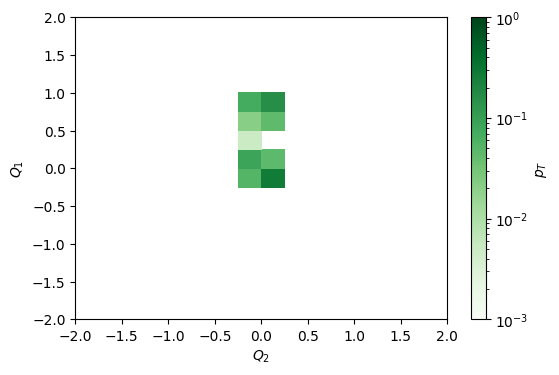

In [12]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime').integrate("event",1),
                            xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1e-3, vmax=1),'cmap':'Greens'})
print(fig)
fig.savefig("Zprime_eventImage.png")

Figure(600x400)


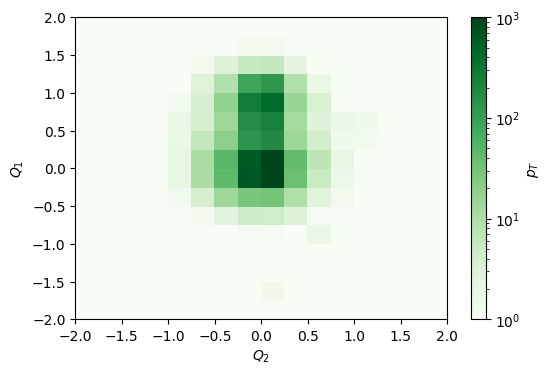

In [13]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime').integrate("event"),
                            xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e3),'cmap':'Greens'})
print(fig)
fig.savefig("Zprime_image.png")

In [14]:
# fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime2TeV').integrate("event"),
#                             xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e3),'cmap':'Greens'})
# print(fig)
# fig.savefig("Zprime2TeV_image.png")

In [15]:
# fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime3TeV').integrate("event"),
#                             xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e3),'cmap':'Greens'})
# print(fig)
# fig.savefig("Zprime3TeV_image.png")

In [16]:
# fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime3TeV').integrate("event",1)
#                             ,xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1e-3, vmax=1),'cmap':'Greens'})
# print(fig)
# fig.savefig("Zprime3TeV_eventImage.png")

Figure(600x400)


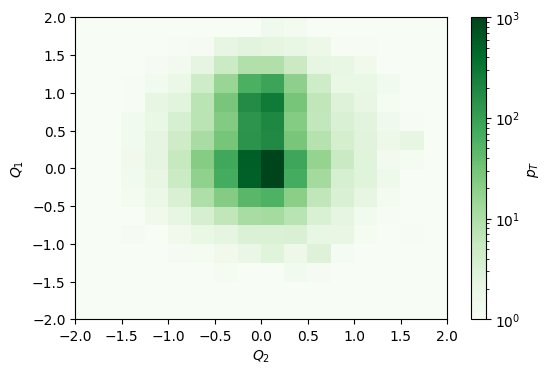

In [17]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'QCD').integrate("event"),
                            xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e3),'cmap':'Greens'})
print(fig)
fig.savefig("QCD_image.png")

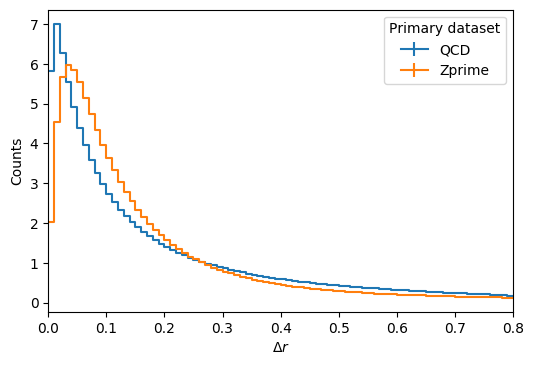

In [18]:
fig, ax = hist.plotgrid(output['dr'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()
fig.savefig("dr_plot.png")

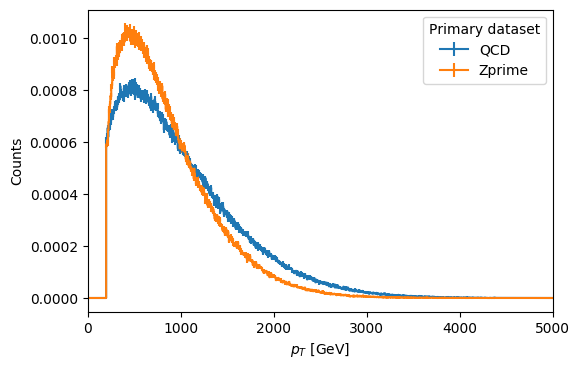

In [19]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()
fig.savefig("pt_plot.png")

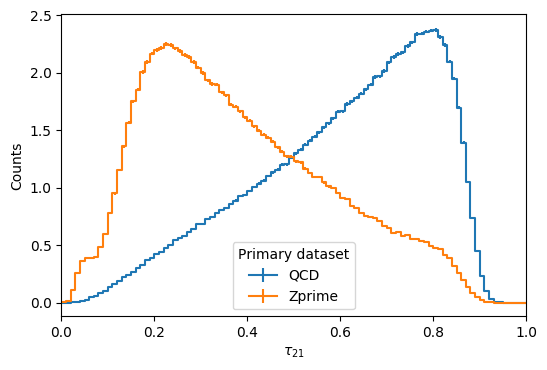

In [20]:
fig, ax = hist.plotgrid(output['tau21'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
    iax.set_xlabel(r'$\tau_{21}$')
fig.show()
fig.savefig("tau_plot.png")

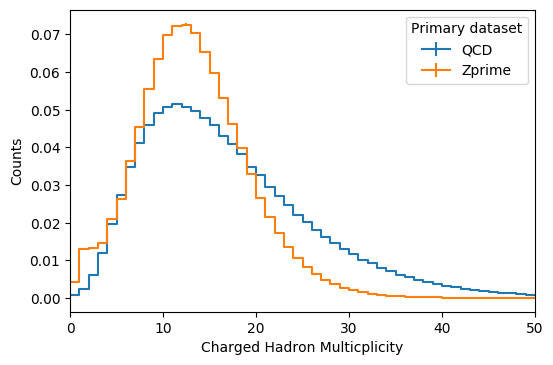

In [21]:
fig, ax = hist.plotgrid(output['h_hadmult'].integrate("hadron","Charged Hadrons"), overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
    iax.set_xlabel("Charged Hadron Multicplicity")
    
fig.show()
fig.savefig("chMult_plot.png")

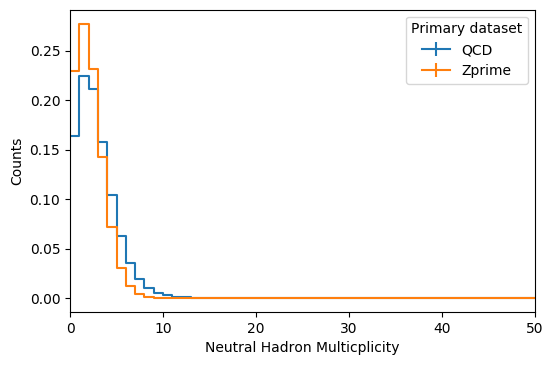

In [22]:
fig, ax = hist.plotgrid(output['h_hadmult'].integrate("hadron","Neutral Hadrons"), overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
    iax.set_xlabel("Neutral Hadron Multicplicity")
    
fig.show()
fig.savefig("neutMult_plot.png")

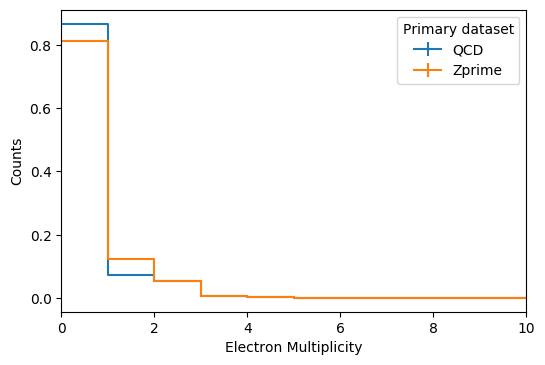

In [23]:
fig, ax = hist.plotgrid(output['h_eleMult'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
    iax.set_xlim([0,10])
#     iax.set_title('Electron Multiplicity')
    iax.set_xlabel('Electron Multiplicity')

fig.show()
fig.savefig("eleMult_plot.png")

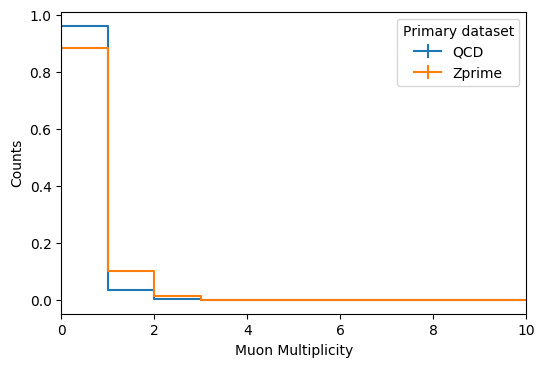

In [24]:
fig, ax = hist.plotgrid(output['h_muMult'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
    iax.set_xlim([0,10])
#     iax.set_title('Muon Multiplicity')
    iax.set_xlabel('Muon Multiplicity')

fig.show()
fig.savefig("muMult_plot.png")

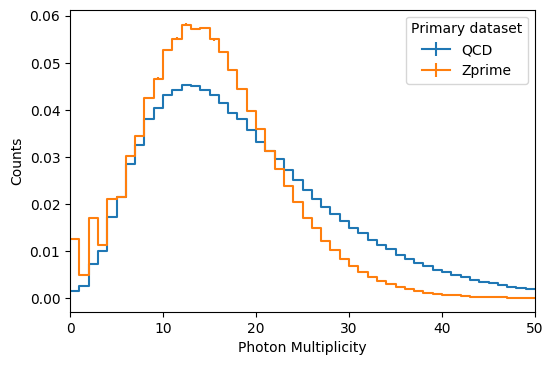

In [25]:
fig, ax = hist.plotgrid(output['h_phoMult'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
#     iax.set_title('Photon Multiplicity')
    iax.set_xlabel('Photon Multiplicity')



fig.show()
fig.savefig("phoMult_plot.png")

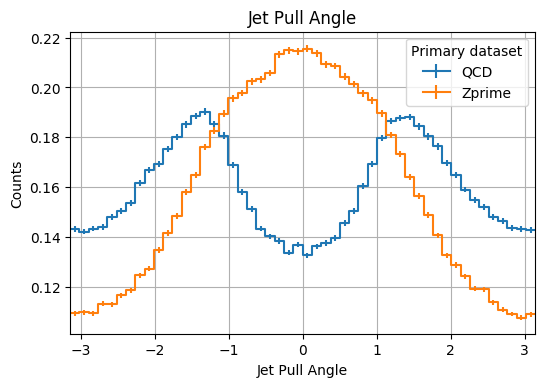

In [26]:
fig, ax = hist.plotgrid(output['h_jetPullAngle'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
    iax.set_title('Jet Pull Angle')
    iax.grid(True)


fig.show()
fig.savefig("pullAngle_plot.png")

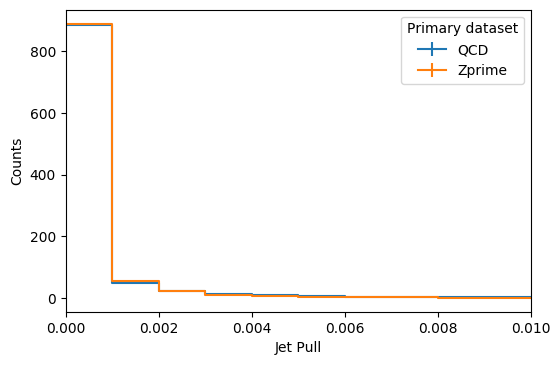

In [27]:
fig, ax = hist.plotgrid(output['h_jetPull'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
#     iax.set_title('Jet Pull')
    iax.set_xlabel('Jet Pull')
    iax.set_xlim([0,0.01])
 
fig.show()
fig.savefig("jetPull_plot.png")